In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import yfinance as yf

## EDA


In [2]:
# Fetch data from Yahoo Finance
df = yf.download(tickers='NVDA', start='2020-01-01')
df_xlk = yf.download(tickers='XLK', start='2020-01-01')

# Check if data has same shape
df.shape, df_xlk.shape

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


((958, 6), (958, 6))

In [24]:
#df.head()
df_xlk.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-16,168.910004,171.020004,168.880005,170.250000,170.250000,7272100
2023-10-17,168.110001,170.339996,166.899994,169.460007,169.460007,7658900
2023-10-18,168.270004,169.639999,167.029999,167.720001,167.720001,6431400
2023-10-19,168.389999,169.520004,166.470001,166.759995,166.759995,9995900
2023-10-20,166.679993,166.800003,163.770004,163.940002,163.940002,7667700


Text(0.5, 1.0, 'NVDA vs XLK Price')

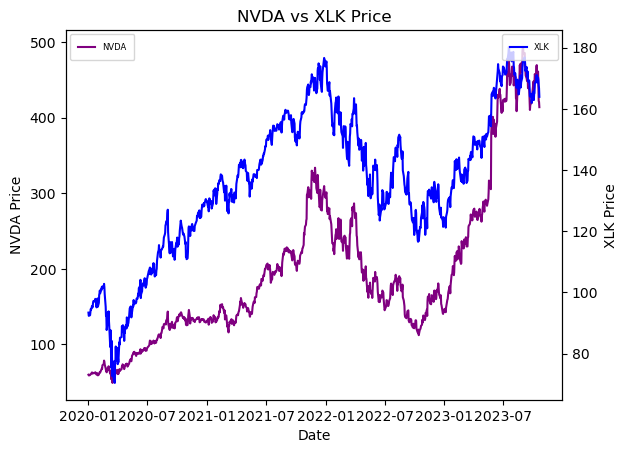

In [4]:
# Finding correlation between NVDA and XLK ETF
fig, ax = plt.subplots()
ax.plot(df['Close'], color='purple', label='NVDA')
ax.set_xlabel('Date')
ax.set_ylabel('NVDA Price')
ax.legend(loc='upper left', borderpad=1, fontsize=6)

ax2 = ax.twinx()
ax2.plot(df_xlk['Close'], color='blue', label='XLK')
ax2.set_ylabel('XLK Price')
ax2.legend(loc='upper right', borderpad=1, fontsize=6)
plt.title('NVDA vs XLK Price')

### Prepare Data

#### Additional Variables Used
- ##### Log Returns: 
    - $\ln(\frac{Current Price}{Original Price})$
    - Log returns measure the percentage change in value over time. This allows us to have a good gauge of the general direction of price.
- ##### Index Funds
    - Index funds are indicators of the general performance of the sector. For this case, the SMA20 of [SPDR Technology Sector Fund (XLK)](https://finance.yahoo.com/quote/XLK?p=XLK) is used as a gauge for the performance of the tech industry as a whole.

In [34]:
# GLOBAL VARS
NUM_VARS = 7
TIMESTEPS = 20
ADJ_CLOSE_INDEX = 3

In [6]:
# Calculate SMA20 for XLK
df['xlk_SMA20'] = df_xlk['Adj Close'].rolling(20).mean()

# Calculate percentage changes
df['log_return'] = np.log(1 + df['Adj Close'].pct_change())

# Drop Close column
df.dropna(inplace=True)
#df.reset_index(inplace=True)
df.drop(['Close'], axis=1, inplace=True)

# Assign a final df for accessing later
final_df = df[TIMESTEPS:]


In [7]:
# Define function to split data
def split(data):
    
    # TIMESTEPS rows will be removed for test data, remaining split 80 20
    test_val_len = len(data) - TIMESTEPS
    l_80 = int(test_val_len * 0.8)
    train_data, val_data, test_data = data[: l_80], data[l_80 : test_val_len], data[test_val_len :]
    return train_data, val_data, test_data

In [8]:
# Define function to create dataset with timesteps
def create_dataset(dataset, timesteps):

    x = []
    y = []
    
    for i in range(len(dataset) - timesteps):
        '''
        for e.g. timesteps = 20
        [add_x] --> [add_y]:
        for one var:
        [0, 1, 2, ... 20] --> [21]
        [1, 2, 3, ... 21] --> [22]

        for multiple vars:
        [[a1, b1, c1], [a2, b2, c2], [a3, b3, c3], ... [a20, b20, c20]] --> [a21, b21, c21]
        '''
        add_x = dataset[i : i + timesteps] # At i = 0, slice from 0 - timesteps
        add_y = dataset[i + timesteps]

        # Extract vars
        add_x = [lst for lst in add_x]

        x.append(add_x)
        y.append(add_y)
    return np.array(x), np.array(y)

In [9]:
# Normalise data
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

# Create datasets
X_full, y_full = create_dataset(df, TIMESTEPS)

# Split data
X_train, X_val, X_test = split(X_full)
y_train, y_val, y_test = split(y_full)

# Shape should be (samples, timesteps, features)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((719, 20, 7), (719, 7), (180, 20, 7), (180, 7), (20, 20, 7), (20, 7))

In [10]:
# Check if values are correct
X_train[1][-1] == y_train[0]

array([ True,  True,  True,  True,  True,  True,  True])

### Stacked LSTM Implementation
Stacked LSTM allows us to process time series data.

In [11]:
# GLOBAL VARS
EPOCHS = 10
INPUT_SHAPE = (TIMESTEPS, NUM_VARS)
VALIDATION_SPLIT = 0.1

In [12]:
# Define model
model = keras.Sequential([

    keras.layers.LSTM(64, return_sequences=True, input_shape=INPUT_SHAPE, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(64, return_sequences=True, activation='relu'),    
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(NUM_VARS, activation='linear')
    
])

model.compile(optimizer='adam', loss='mse')
model.summary()

2023-10-21 20:57:26.726886: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-21 20:57:26.726908: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-21 20:57:26.726914: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-21 20:57:26.726950: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-21 20:57:26.726968: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            18432     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 128)           98816     
                                                                 
 dropout_1 (Dropout)         (None, 20, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 20, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 20, 64)            4

In [13]:
# Train model
model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), batch_size=64)

Epoch 1/10


2023-10-21 20:57:28.862436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 41s 3s/step - loss: 0.1025 - val_loss: 0.0793
Epoch 2/10
12/12 [==============================] - 36s 3s/step - loss: 0.0227 - val_loss: 0.0713
Epoch 3/10
12/12 [==============================] - 36s 3s/step - loss: 0.0138 - val_loss: 0.0535
Epoch 4/10
12/12 [==============================] - 36s 3s/step - loss: 0.0118 - val_loss: 0.0519
Epoch 5/10
12/12 [==============================] - 38s 3s/step - loss: 0.0103 - val_loss: 0.0486
Epoch 6/10
12/12 [==============================] - 37s 3s/step - loss: 0.0091 - val_loss: 0.0386
Epoch 7/10
12/12 [==============================] - 36s 3s/step - loss: 0.0081 - val_loss: 0.0309
Epoch 8/10
12/12 [==============================] - 37s 3s/step - loss: 0.0073 - val_loss: 0.0292
Epoch 9/10
12/12 [==============================] - 37s 3s/step - loss: 0.0067 - val_loss: 0.0256
Epoch 10/10
12/12 [==============================] - 37s 3s/step - loss: 0.0062 - val_loss: 0.0269


### Test Data

In [ ]:
# Prediction on test data
# train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get original format
# train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
# y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

In [ ]:
test_predict = [rows[ADJ_CLOSE_INDEX] for rows in test_predict]
y_test = [rows[ADJ_CLOSE_INDEX] for rows in y_test]

In [18]:
#train_results = pd.DataFrame(data={'Predictions': train_predict, 'Actual': y_train})
test_results = pd.DataFrame(data={'Predictions': test_predict, 'Actual': y_test})

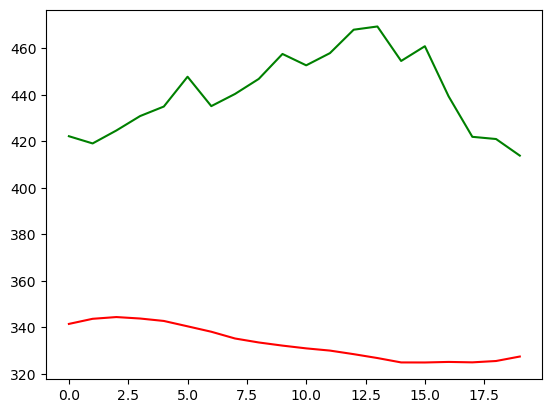

In [55]:
plt.plot(test_results['Predictions'], color = 'red')
plt.plot(test_results['Actual'], color = 'green')

In [64]:
# Define function to predict
def get_predictions(days, data):
    
    predictions = []

    # Select the last row which contains past TIMESTEPS rows of data.
    data = data[-1]
    
    for i in range(days):
        
        # Reshape data for prediction input
        data = np.reshape(data, (1, TIMESTEPS, NUM_VARS))

        prediction = model.predict(data)
        predictions.append(prediction)

        # Remove first day from window
        data = data[0][1:]

        # Reshape prediction and add back to prediction input
        data = np.concatenate([data, prediction], axis=0)
    
    predictions = scaler.inverse_transform(data)
    predictions = pd.DataFrame(predictions)
    return predictions


In [65]:
get_predictions(10, X_test)

1/1 [==============================] - 0s 181ms/step


,0,1,2,3,4,5,6
0,441.929993,457.890015,440.260010,457.619995,4.333970e+07,166.571242,0.023749
1,448.420013,456.049988,443.679993,452.730011,4.096750e+07,166.359752,-0.010743
2,453.100006,462.589996,450.880005,457.980011,3.685820e+07,166.318427,0.011530
3,461.959991,468.589996,460.500000,468.059998,3.781370e+07,166.334148,0.021771
4,467.769989,476.089996,463.299988,469.450012,4.813250e+07,166.296001,0.002965
5,469.600006,471.160004,452.799988,454.609985,4.741150e+07,166.300501,-0.032122
6,450.630005,462.250000,449.119995,460.950012,3.750990e+07,166.345501,0.013850
7,440.000000,447.540009,424.799988,439.380005,8.123330e+07,166.355502,-0.047925
8,425.910004,432.190002,418.250000,421.959991,6.272940e+07,166.411501,-0.040454
9,428.109985,432.970001,418.820007,421.010010,5.012330e+07,166.546501,-0.002254


In [66]:
final_pred = get_predictions(10, X_test) 

1/1 [==============================] - 0s 177ms/step


In [ ]:
# Calculate RMSE
#train_rmse = mean_squared_error(y_train, train_predict, squared=False)

In [ ]:
# Define Function to calculate rmse
def calc_rmse(actual, predictions):
    return mean_squared_error(actual, predictions, squared=False)